<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_certification_training/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-37c1eee0-bc12-c68f-5125-c67e2eb5a591)


## Get the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [ ]:
# Create a function to read thelines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.
  
  Returns:
    A list of strings with one string per line from the target filename.
    """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
# Let's write a function which turns each of our datasets into a dctionnary format
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Take in filename, reads it contents and sorts through each line,
  extracting thongs like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty string
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_split, text_split = abstract_line.split("\t")
        line_data["target"] = target_split
        line_data["text"] = text_split.lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
      
    else:
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution in the training_data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

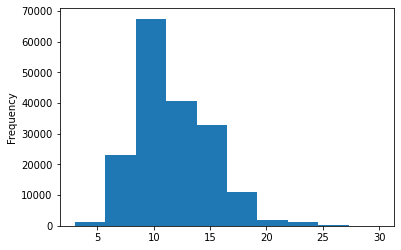

In [ ]:
# Let's check the lengh of different lines
train_df.total_lines.plot.hist();

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoder = label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoder = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoder = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_label_encoder

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [ ]:
# Fit the model
model_0.fit(X=train_sentences,
            y=train_label_encoder)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline
model_0.score(X=val_sentences,
              y=val_label_encoder)

0.7218323844829869

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Download our heper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-24 02:08:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-24 02:08:44 (96.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_label_encoder,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Check the average len of our sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

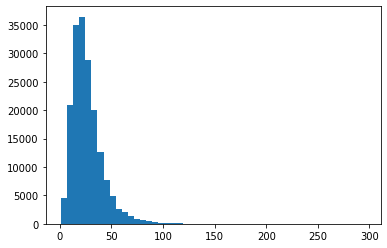

In [ ]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50);

In [ ]:
# How longof a sentence lenght covers 95% of examples ?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

## Create text vectorizer layer

In [ ]:
max_tokens = 68000

In [ ]:
# Create the text vectorization layer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of different words
                                    output_sequence_length=output_seq_len) # max number of word per sequence i.e. 55

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Check the results through randomness
import random
random_text = random.choice(train_sentences)
print(f"Text: {random_text}")
print(f"Length: {len(random_text.split())}")
print(f"Vectorized text: {text_vectorizer([random_text])}")

Text: primary outcome will be comparative changes in perceived stress ( pss ) .
Length: 13
Vectorized text: [[  56   86   95   36 1502  146    5  813  401 7167    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create the embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding
token_embed = Embedding(input_dim=len(rct_20k_text_vocab), #68000
                      output_dim=128,
                      mask_zero=True, # mask 0 from variable inputs
                      input_length=55,
                      name="token_embedding")

In [ ]:
print(f"Text: {random_text}\n")
vectorized_sentence = text_vectorizer([random_text])
print(f"Vectorized text: {vectorized_sentence}\n")
print(f"Embedded text: {token_embed(vectorized_sentence)}\n")
print(f"Embedded shape: {token_embed(vectorized_sentence).shape}")

Text: primary outcome will be comparative changes in perceived stress ( pss ) .

Vectorized text: [[  56   86   95   36 1502  146    5  813  401 7167    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded text: [[[-0.00925324  0.00069695  0.00098366 ... -0.00817811 -0.03348844
   -0.04914094]
  [ 0.0172671   0.00445665  0.0403561  ...  0.01809466 -0.02291472
    0.01550916]
  [ 0.00225963 -0.03939413 -0.03294647 ... -0.04163834  0.03352537
    0.01131687]
  ...
  [-0.02844893  0.02976744  0.03747315 ...  0.04397947 -0.00415964
    0.0148969 ]
  [-0.02844893  0.02976744  0.03747315 ...  0.04397947 -0.00415964
    0.0148969 ]
  [-0.02844893  0.02976744  0.03747315 ...  0.04397947 -0.00415964
    0.0148969 ]]]

Embedded shape: (1, 55, 128)


## Creating datasets

In [ ]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn then into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_datset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create model1
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorizer_layer = text_vectorizer(inputs)
embedding_layer = token_embed(vectorizer_layer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedding_layer)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax", name="output")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

In [ ]:
# Comnpile model 1
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output (Dense)              (None, 5)              

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              epochs=3,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.8468 - accuracy: 0.6810 - val_loss: 0.5878 - val_accuracy: 0.7839
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5792 - accuracy: 0.7867 - val_loss: 0.5405 - val_accuracy: 0.7985
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.5459 - accuracy: 0.7997 - val_loss: 0.5198 - val_accuracy: 0.8155


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5230 - accuracy: 0.8068


[0.5229666233062744, 0.8068317174911499]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:5]

945/945 [==============================] - 2s 2ms/step


array([[5.72510660e-01, 9.43202227e-02, 4.18646447e-03, 3.25290859e-01,
        3.69183696e-03],
       [1.78545922e-01, 6.42057240e-01, 6.05932088e-04, 1.73629329e-01,
        5.16155688e-03],
       [2.04854816e-01, 1.27288252e-02, 6.57354947e-03, 7.75413752e-01,
        4.29101579e-04],
       [2.84214830e-03, 1.16554145e-02, 9.22820151e-01, 2.93791876e-03,
        5.97442724e-02],
       [3.01306299e-03, 3.20781097e-02, 5.24858475e-01, 1.48586975e-03,
        4.38564569e-01]], dtype=float32)

In [ ]:
# Convert to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 2])>

In [ ]:
# Calculate model_1_results
model_1_results = calculate_results(y_true=val_label_encoder,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 80.6831722494373,
 'precision': 0.8054823416659437,
 'recall': 0.8068317224943731,
 'f1': 0.8054810493613359}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Transfer learning USE

In [ ]:
import tensorflow_hub as hub

In [ ]:
use_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                               trainable=False,
                               name="USE")

In [ ]:
# check with random sentence pick up
random_sentence = random.choice(train_sentences)
print(f"Text: \n{random_sentence} \n")
embedded_random = use_embedding([random_sentence])
print(f"Embedded: \n{embedded_random[0][:30]}\n")
print(f"Shape: {len(embedded_random[0])}")

Text: 
the interaction between patient race and intervention condition ( proactive care vs. usual care ) was not significant . 

Embedded: 
[-0.04645857 -0.0411411  -0.05708411  0.05022511  0.03723221  0.02835233
 -0.05150785 -0.01339924  0.04182621  0.04942587  0.08355401  0.02961395
 -0.03193291  0.03327369  0.01184828 -0.02761028 -0.08458007  0.05505245
 -0.03811137  0.02942272  0.07674602  0.07187143  0.06682426 -0.05713924
 -0.00957848  0.00936153 -0.01543443  0.02652934 -0.04529679 -0.00420719]

Shape: 512


In [ ]:
# Create model 2:
inputs = layers.Input(shape=[], dtype=tf.string)
embedding = use_embedding(inputs)
x = layers.Dense(128, activation="relu")(embedding)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE")

In [ ]:
# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              validation_data=valid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9164 - accuracy: 0.6492 - val_loss: 0.7974 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7681 - accuracy: 0.7026 - val_loss: 0.7544 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7514 - accuracy: 0.7137 - val_loss: 0.7375 - val_accuracy: 0.7168


In [ ]:
# Evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7408 - accuracy: 0.7148


[0.7408132553100586, 0.7148153185844421]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)

945/945 [==============================] - 8s 9ms/step


In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate the results
model_2_results = calculate_results(y_true = val_label_encoder,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.4815305176751,
 'precision': 0.7153947023433814,
 'recall': 0.714815305176751,
 'f1': 0.7117169086302607}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### Create a character level tokenizer

In [ ]:
# example
phrase = "I love tensorflow"
" ".join(list(phrase))

'I   l o v e   t e n s o r f l o w'

In [ ]:
# Make a function
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Split seqience-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
# What's the average character length
chars_lens = [len(chars) for chars in train_sentences]
chars_lens_avg = np.mean(chars_lens)
chars_lens_avg

149.3662574983337

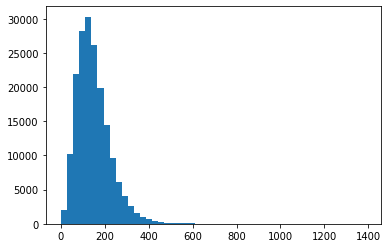

In [ ]:
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=50);

In [ ]:
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV (['UKN'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common charcaters: {char_vocab[-5:]}")

Number of different characters: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common charcaters: ['|', '"', ']', '\\', '[']


In [ ]:
# Test out character vectorizer
random_char = random.choice(train_chars)
print(f"Text: {random_char}\n")
print(f"Length: {len(random_char.split())}\n")
vect_char = char_vectorizer(random_char)
print(f"Vectorized: {vect_char}")

Text: m u l t i v a r i a b l e   a n a l y s e s   w e r e   u s e d   t o   i d e n t i f y   p r e d i c t o r s   o f   c i - a k i   ,   a s   w e l l   p r e d i c t o r s   o f   t h e   p r i m a r y   a n d   s e c o n d a r y   e n d p o i n t s   .

Length: 108

Vectorized: [15 16 12  3  4 22  5  8  4  5 23 12  2  5  6  5 12 20  9  2  9 21  2  8
  2 16  9  2 10  3  7  4 10  2  6  3  4 17 20 14  8  2 10  4 11  3  7  8
  9  7 17 11  4 26  5 29  4 24  5  9 21  2 12 12 14  8  2 10  4 11  3  7
  8  9  7 17  3 13  2 14  8  4 15  5  8 20  5  6 10  9  2 11  7  6 10  5
  8 20  2  6 10 14  7  4  6  3  9 25  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Create a character level embedding

In [ ]:
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=25, # following the paper (normally mu;tiple of 8 usually 128 or 256 or 512)
                                       mask_zero=True,
                                       input_length=output_seq_char_len)

In [ ]:
# Test out charcacter embedding layer
random_char = random.choice(train_chars)
print(f"Text: \n{random_char}\n")
vect_char = char_vectorizer([random_char])
print(f"Vect: \n{vect_char}\n")
embed_char = char_embed(vect_char)
print(f"Embed: \n{embed_char[0][0][:30]}")
print(f"Emdeb shape: {embed_char.shape}")

Text: 
r e s t a g i n g   u s i n g   c t   a f t e r   n e o a d j u v a n t   c h e m o t h e r a p y   f o r   g a s t r i c   c a n c e r   i s   c o n s i d e r e d   t o   b e   i n a c c u r a t e   a n d   u n r e l i a b l e   .

Vect: 
[[ 8  2  9  3  5 18  4  6 18 16  9  4  6 18 11  3  5 17  3  2  8  6  2  7
   5 10 37 16 22  5  6  3 11 13  2 15  7  3 13  2  8  5 14 20 17  7  8 18
   5  9  3  8  4 11 11  5  6 11  2  8  4  9 11  7  6  9  4 10  2  8  2 10
   3  7 23  2  4  6  5 11 11 16  8  5  3  2  5  6 10 16  6  8  2 12  4  5
  23 12  2 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

## Model 3: Conv1D with character embedding

In [ ]:
# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
vect_char = char_vectorizer(inputs)
embed_char = char_embed(vect_char)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(embed_char)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_char")

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 5)                

In [ ]:
# Create char level tensorflow datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices(tensors=(train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
train_char_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_char_dataset = train_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# fit the model
history_model_3 = model_3.fit(train_char_dataset,
                              validation_data=val_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 3s 5ms/step - loss: 1.1804 - accuracy: 0.5338 - val_loss: 0.9689 - val_accuracy: 0.6157
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9128 - accuracy: 0.6356 - val_loss: 0.8485 - val_accuracy: 0.6742
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8322 - accuracy: 0.6752 - val_loss: 0.7851 - val_accuracy: 0.6985
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.7832 - accuracy: 0.6981 - val_loss: 0.7598 - val_accuracy: 0.7151
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.7701 - accuracy: 0.7048 - val_loss: 0.7331 - val_accuracy: 0.7214


In [ ]:
# Evaluate the model
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7475 - accuracy: 0.7125


[0.7475350499153137, 0.7125314474105835]

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
# Turn probs into preds
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [ ]:
# Calculate results
model_3_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 71.25314444591552,
 'precision': 0.7218505559153535,
 'recall': 0.7125314444591553,
 'f1': 0.7055253685162447}

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding layer)

In [ ]:
# Create token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embed = use_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Create chars inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vect = char_vectorizer(char_inputs)
char_embed_lay = char_embed(char_vect)
char_outputs = layers.Bidirectional(layers.LSTM(25))(char_embed_lay)
char_model = tf.keras.Model(char_inputs, char_outputs)

# Combine token/char
combined = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                         char_model.output])

# Create output layer and dropout layer
combined_dropout = layers.Dropout(0.5)(combined)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
#final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(combined_dense) #(final_dropout)

# Build the model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], 
                         outputs=output_layer,
                         name="model_4_concat")

In [ ]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]'

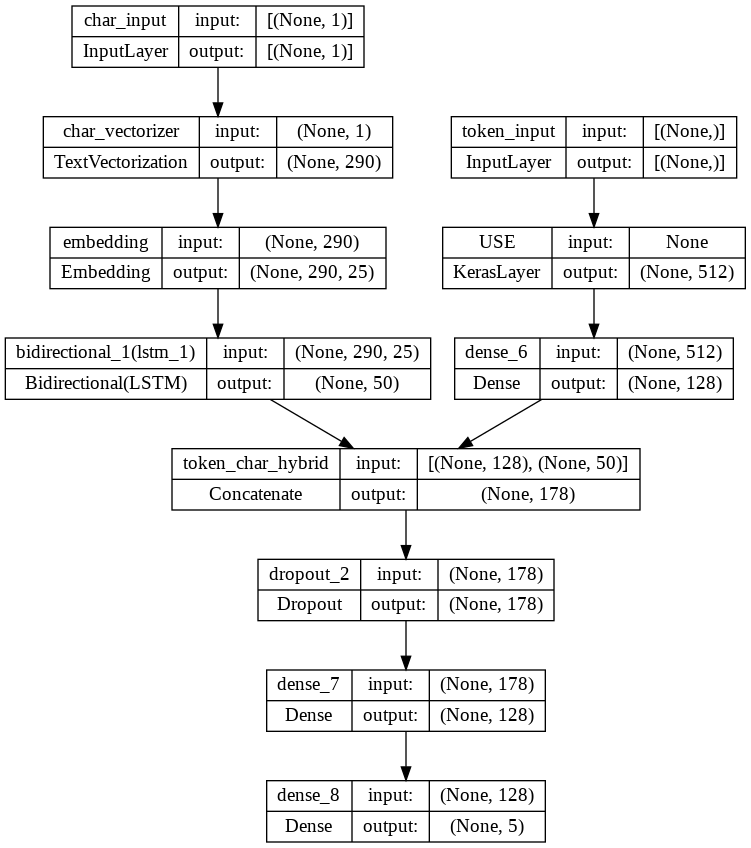

In [ ]:
# Plot hybrid models
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Creating tf.data.Datasets for our hybrid model

In [ ]:
train_hybrid_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars), train_labels_one_hot))
val_hybrid_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars), val_labels_one_hot))
test_hybrid_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars), test_labels_one_hot))

train_hybrid_dataset

<TensorSliceDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_hybrid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_hybrid_dataset,
                              validation_data=val_hybrid_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_hybrid_dataset)),
                              validation_steps=int(0.1*len(val_hybrid_dataset)))

Epoch 1/5
562/562 [==============================] - 31s 39ms/step - loss: 0.9741 - accuracy: 0.6132 - val_loss: 0.7779 - val_accuracy: 0.6955
Epoch 2/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7662 - accuracy: 0.7036 - val_loss: 0.7088 - val_accuracy: 0.7247
Epoch 3/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7367 - accuracy: 0.7157 - val_loss: 0.6832 - val_accuracy: 0.7400
Epoch 4/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7063 - accuracy: 0.7318 - val_loss: 0.6658 - val_accuracy: 0.7414
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7132 - accuracy: 0.7274 - val_loss: 0.6485 - val_accuracy: 0.7493


In [ ]:
# Evaluate the model
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 22s 18ms/step - loss: 1.6041 - accuracy: 0.2161


[1.6040631532669067, 0.2161392867565155]

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_hybrid_dataset)

945/945 [==============================] - 20s 18ms/step


In [ ]:
# Probs to pred
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])>

In [ ]:
# Calculate our model results
model_4_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.17582417582418,
 'precision': 0.743159930278167,
 'recall': 0.7417582417582418,
 'f1': 0.7394339733124754}

## Model 5: Cobiming token + characters + position (my experiment)

In [ ]:
train_pos = (train_df.line_number / train_df.total_lines).to_numpy()
val_pos = (val_df.line_number / val_df.total_lines).to_numpy()
test_pos = (test_df.line_number / test_df.total_lines).to_numpy()

In [ ]:
# Build the model 5

# Create the token model
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embed = use_embedding(token_input)
token_x = layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu")(tf.expand_dims(token_embed, axis=1))
token_x = layers.GlobalMaxPool1D()(token_x)
token_outputs = layers.Dense(128, activation="relu")(token_x)

token_model = tf.keras.Model(token_input, token_outputs)

# Create the character model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vect = char_vectorizer(char_input)
char_embed_lay = char_embed(char_vect)
char_x = layers.Bidirectional(layers.LSTM(25))(char_embed_lay)
char_output = layers.Dense(64, activation="relu")(char_x)

char_model = tf.keras.Model(char_input, char_output)

# Create the positional model
pos_input = layers.Input(shape=(1), dtype=tf.float32, name="pos_input")
pos_x = layers.Dense(32, activation="relu")(pos_input)
pos_output = layers.Dense(16, activation="relu")(pos_x)

pos_model = tf.keras.Model(pos_input, pos_output)

# Concatenate the model
concat_layer = layers.Concatenate(name="concat_model_5")([token_model.output,
                                                          char_model.output,
                                                          pos_model.output])

# Final model 5
x = layers.Dropout(0.3)(concat_layer)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(5, activation="softmax")(x)

model_5 = tf.keras.Model([token_model.input, char_model.input, pos_model.input], output)

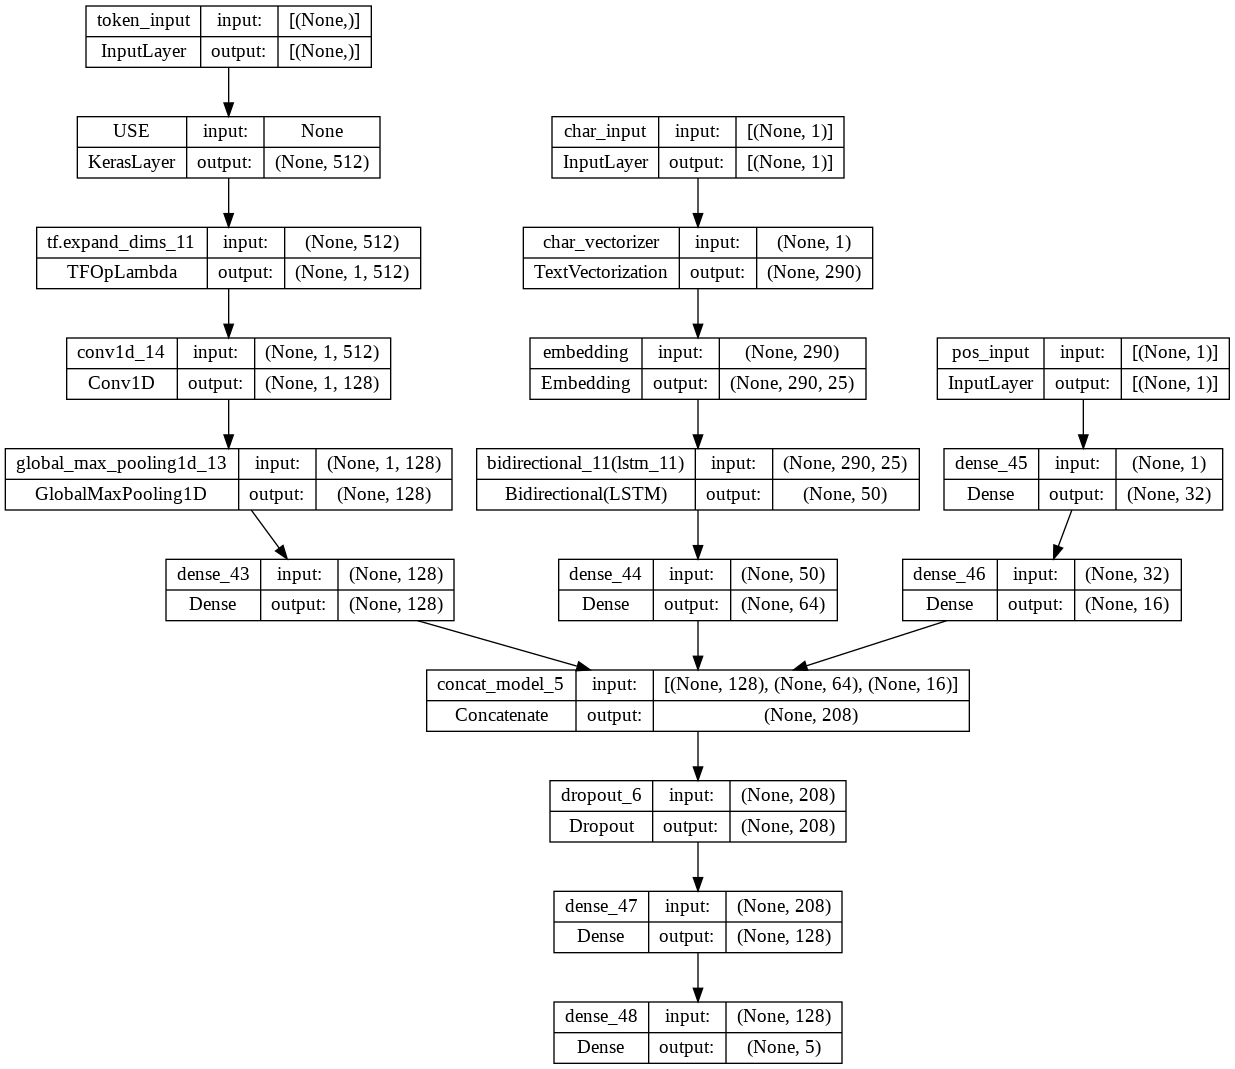

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
train_model_5_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars, train_pos), train_labels_one_hot))
val_model_5_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars, val_pos), val_labels_one_hot))
test_model_5_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars, test_pos), test_labels_one_hot))

In [ ]:
train_model_5_dataset = train_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_model_5_dataset = val_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_model_5_dataset = test_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5_history = model_5.fit(train_model_5_dataset,
                              validation_data=val_model_5_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_model_5_dataset)),
                              validation_steps=int(0.1*len(val_model_5_dataset)))

Epoch 1/5
562/562 [==============================] - 32s 41ms/step - loss: 0.6552 - accuracy: 0.7471 - val_loss: 0.4453 - val_accuracy: 0.8318
Epoch 2/5
562/562 [==============================] - 20s 36ms/step - loss: 0.4504 - accuracy: 0.8313 - val_loss: 0.3982 - val_accuracy: 0.8481
Epoch 3/5
562/562 [==============================] - 20s 36ms/step - loss: 0.4241 - accuracy: 0.8337 - val_loss: 0.3685 - val_accuracy: 0.8664
Epoch 4/5
562/562 [==============================] - 20s 35ms/step - loss: 0.4085 - accuracy: 0.8459 - val_loss: 0.3604 - val_accuracy: 0.8570
Epoch 5/5
562/562 [==============================] - 20s 35ms/step - loss: 0.3954 - accuracy: 0.8499 - val_loss: 0.3583 - val_accuracy: 0.8654


In [ ]:
# Evaluate the model
model_5.evaluate(val_model_5_dataset)

945/945 [==============================] - 18s 20ms/step - loss: 0.3580 - accuracy: 0.8618


[0.3579752743244171, 0.8618429899215698]

In [ ]:
# Make preds
model_5_pred_probs = model_5.predict(val_model_5_dataset)

945/945 [==============================] - 20s 19ms/step


In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results
model_5_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.18429763008076,
 'precision': 0.8674922074198872,
 'recall': 0.8618429763008076,
 'f1': 0.8581945437776042}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 80.6831722494373,
 'precision': 0.8054823416659437,
 'recall': 0.8068317224943731,
 'f1': 0.8054810493613359}

## Model 5: Daniel experiment

### Create positional embeddings

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

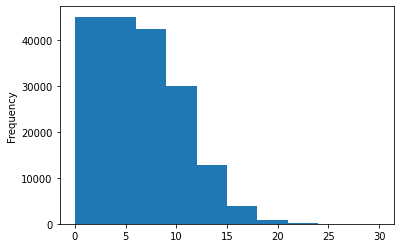

In [ ]:
# Check the distribution
train_df.line_number.plot.hist()

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

train_line_number_one_hot[40:55]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

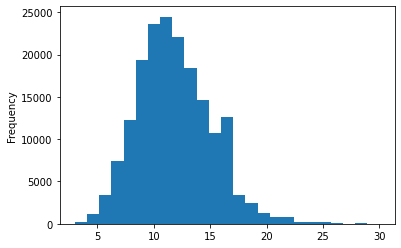

In [ ]:
train_df.total_lines.plot.hist(bins=25);

In [ ]:
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
train_total_line_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_line_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [ ]:
# Create the model

# Token inputs
token_input = layers.Input(shape=[], dtype=tf.string)
token_embedding = use_embedding(token_input)
token_output = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_input,
                             token_output)

# Char inputs
char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vect = char_vectorizer(char_input)
char_embedding = char_embed(char_vect)
char_output = layers.Bidirectional(layers.LSTM(25))(char_embedding)
char_model = tf.keras.Model(char_input,
                            char_output)

# Line number model
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_output = layers.Dense(32, activation="relu")(line_number_input)
line_number_model = tf.keras.Model(line_number_input,
                                   line_number_output)

# Total line model
total_number_input = layers.Input(shape=(20,), dtype=tf.float32, name="total_number_input")
total_number_output = layers.Dense(32, activation="relu")(total_number_input)
total_number_model = tf.keras.Model(total_number_input, 
                                    total_number_output)

# Combine token and char embedding
combined_embeddings = layers.Concatenate(name="char_token_concat")([token_model.output,
                                                                    char_model.output])

x = layers.Dense(256, activation="relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)

# Combine positionsl embeddong with concat
all_concat = layers.Concatenate(name="all_concat")([line_number_model.output,
                                                    total_number_model.output,
                                                    x])

# Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(all_concat)

# Put together our model
model_6 = tf.keras.Model(inputs=[line_number_model.input, 
                                 total_number_model.input,
                                 token_model.input,
                                 char_model.input], 
                         outputs=output_layer)

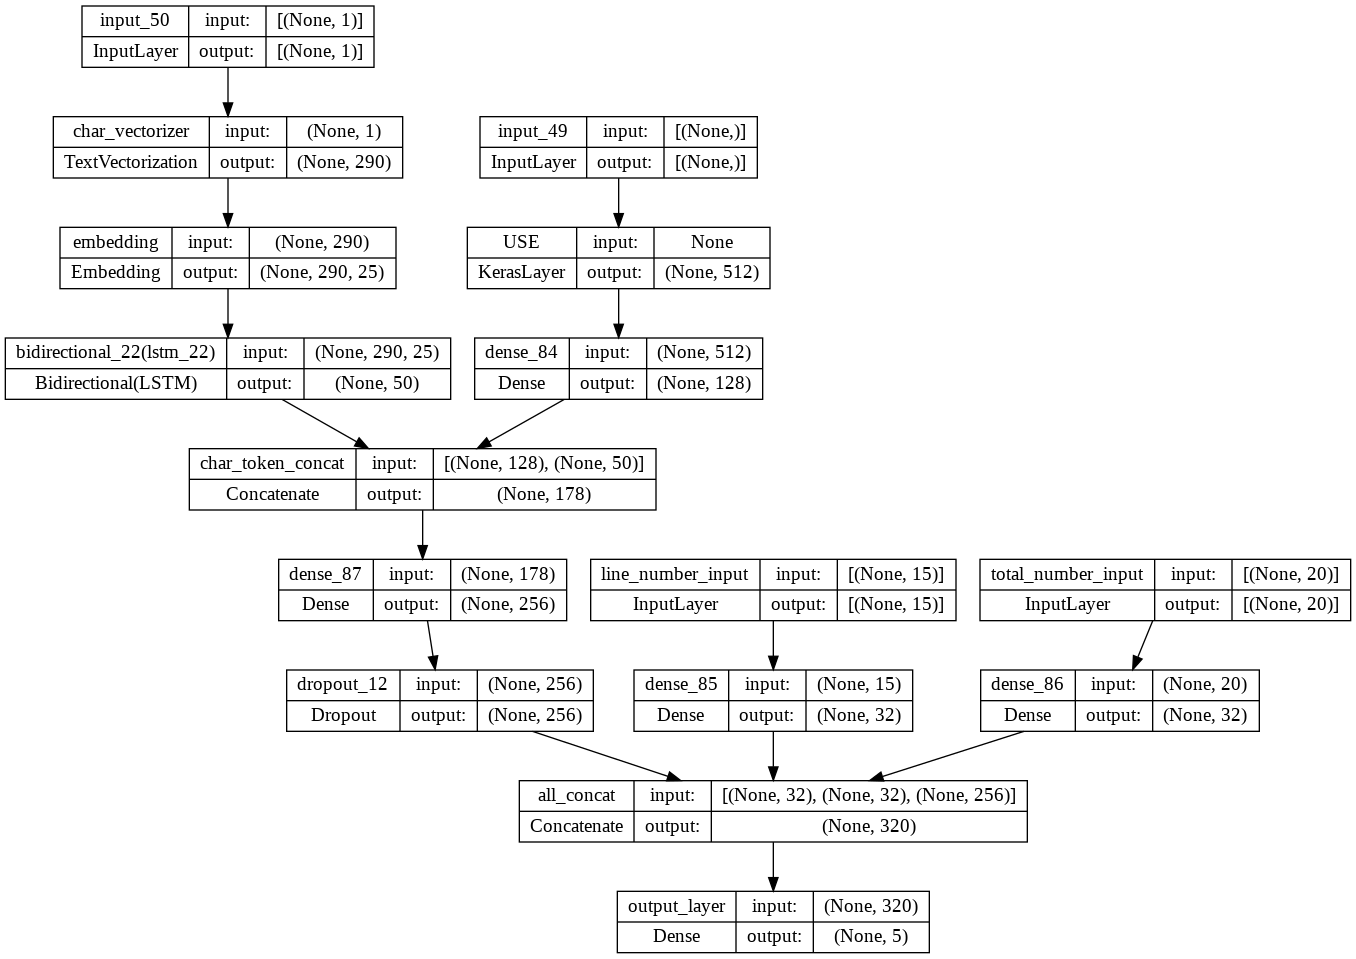

In [ ]:
plot_model(model_6, show_shapes=True)

In [ ]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Prepare the dataset
train_model_6_dataset = tf.data.Dataset.from_tensor_slices(((train_line_number_one_hot, 
                                                             train_total_line_one_hot, 
                                                             train_sentences, 
                                                             train_chars),
                                                            train_labels_one_hot))
val_model_6_dataset = tf.data.Dataset.from_tensor_slices(((val_line_number_one_hot, 
                                                             val_total_line_one_hot, 
                                                             val_sentences, 
                                                             val_chars),
                                                            val_labels_one_hot))
test_model_6_dataset = tf.data.Dataset.from_tensor_slices(((test_line_number_one_hot, 
                                                             test_total_line_one_hot, 
                                                             test_sentences, 
                                                             test_chars),
                                                            test_labels_one_hot))

In [ ]:
train_model_6_dataset = train_model_6_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_model_6_dataset = val_model_6_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_model_6_dataset = test_model_6_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_model_6_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
model_6_history = model_6.fit(train_model_6_dataset,
                              validation_data=val_model_6_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_model_6_dataset)),
                              validation_steps=int(0.1*len(val_model_6_dataset)))

Epoch 1/5
562/562 [==============================] - 32s 40ms/step - loss: 1.0901 - accuracy: 0.7286 - val_loss: 0.9802 - val_accuracy: 0.7995
Epoch 2/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9589 - accuracy: 0.8207 - val_loss: 0.9447 - val_accuracy: 0.8308
Epoch 3/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9420 - accuracy: 0.8319 - val_loss: 0.9293 - val_accuracy: 0.8388
Epoch 4/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9289 - accuracy: 0.8416 - val_loss: 0.9228 - val_accuracy: 0.8384
Epoch 5/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9256 - accuracy: 0.8451 - val_loss: 0.9164 - val_accuracy: 0.8467


In [ ]:
# Make predictions
model_6_pred_probs = model_6.predict(val_model_6_dataset)

945/945 [==============================] - 24s 22ms/step


In [ ]:
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

In [ ]:
# Calculate results
model_6_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 84.95630875148947,
 'precision': 0.8531010751750839,
 'recall': 0.8495630875148947,
 'f1': 0.8459463536907131}

In [ ]:
model_5_results

{'accuracy': 86.18429763008076,
 'precision': 0.8674922074198872,
 'recall': 0.8618429763008076,
 'f1': 0.8581945437776042}

## Compare all model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results})
all_model_results = all_model_results.transpose()

In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1,80.683172,0.805482,0.806832,0.805481
model_2,71.481531,0.715395,0.714815,0.711717
model_3,71.253144,0.721851,0.712531,0.705525
model_4,74.175824,0.743160,0.741758,0.739434
model_5,86.184298,0.867492,0.861843,0.858195
model_6,84.956309,0.853101,0.849563,0.845946


In [ ]:
all_model_results.accuracy = all_model_results.accuracy / 100

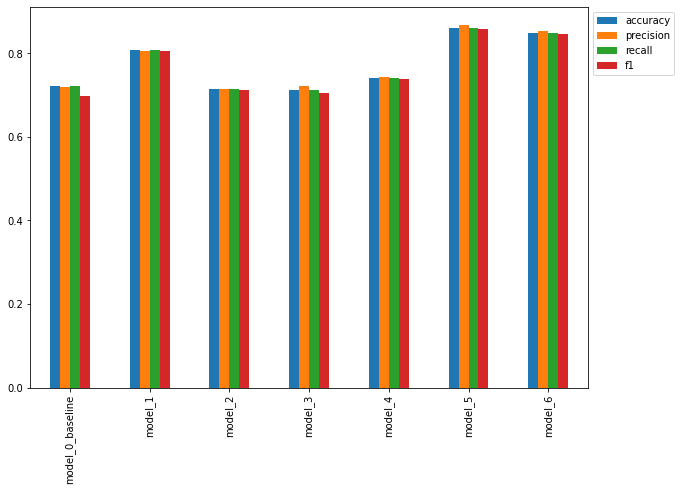

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

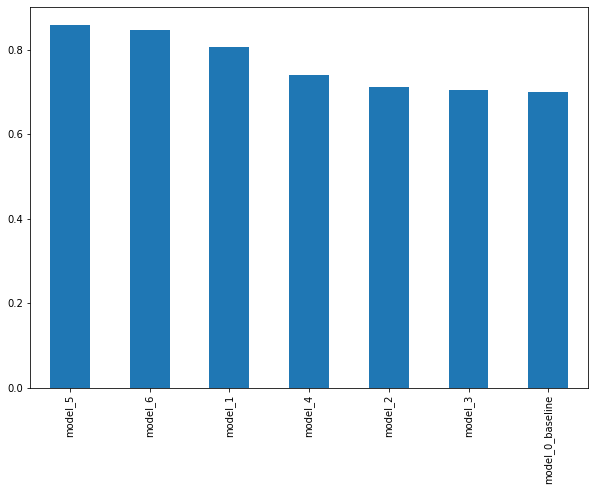

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Final perso model 7

In [ ]:
#Model 7

# tokens
token_input = layers.Input(shape=(1,), dtype=tf.string)
token_vect = text_vectorizer(token_input)
token_embedding = token_embed(token_vect)
token_conv1d = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embedding)
token_output = layers.GlobalMaxPool1D()(token_conv1d)
token_model = tf.keras.Model(token_input, token_output)

# chars
char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vect = char_vectorizer(char_input)
char_embedding = char_embed(char_vect)
char_conv1d = layers.Conv1D(64, kernel_size=9, padding="same", activation="relu")(char_embedding)
char_output = layers.GlobalMaxPool1D()(char_conv1d)
char_model = tf.keras.Model(char_input, char_output)

# pos
pos_input = layers.Input(shape=(1,), dtype=tf.float32)
pos_output = layers.Dense(64, activation="relu")(pos_input)
pos_model = tf.keras.Model(pos_input, pos_output)

# Concatenate
x = layers.Concatenate()([token_model.output,
                          char_model.output,
                          pos_model.output])
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation="softmax")(x)

model_7 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 pos_model.input],
                         outputs=output)

In [ ]:
# compile
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
model_7_history = model_7.fit(train_model_5_dataset,
                              validation_data=val_model_5_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_model_5_dataset)),
                              validation_steps = int(0.1*len(val_model_5_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 10ms/step - loss: 1.0179 - accuracy: 0.7752 - val_loss: 0.8977 - val_accuracy: 0.8617
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8948 - accuracy: 0.8649 - val_loss: 0.8708 - val_accuracy: 0.8790
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8821 - accuracy: 0.8709 - val_loss: 0.8643 - val_accuracy: 0.8733
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8723 - accuracy: 0.8786 - val_loss: 0.8657 - val_accuracy: 0.8720
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8703 - accuracy: 0.8782 - val_loss: 0.8579 - val_accuracy: 0.8863


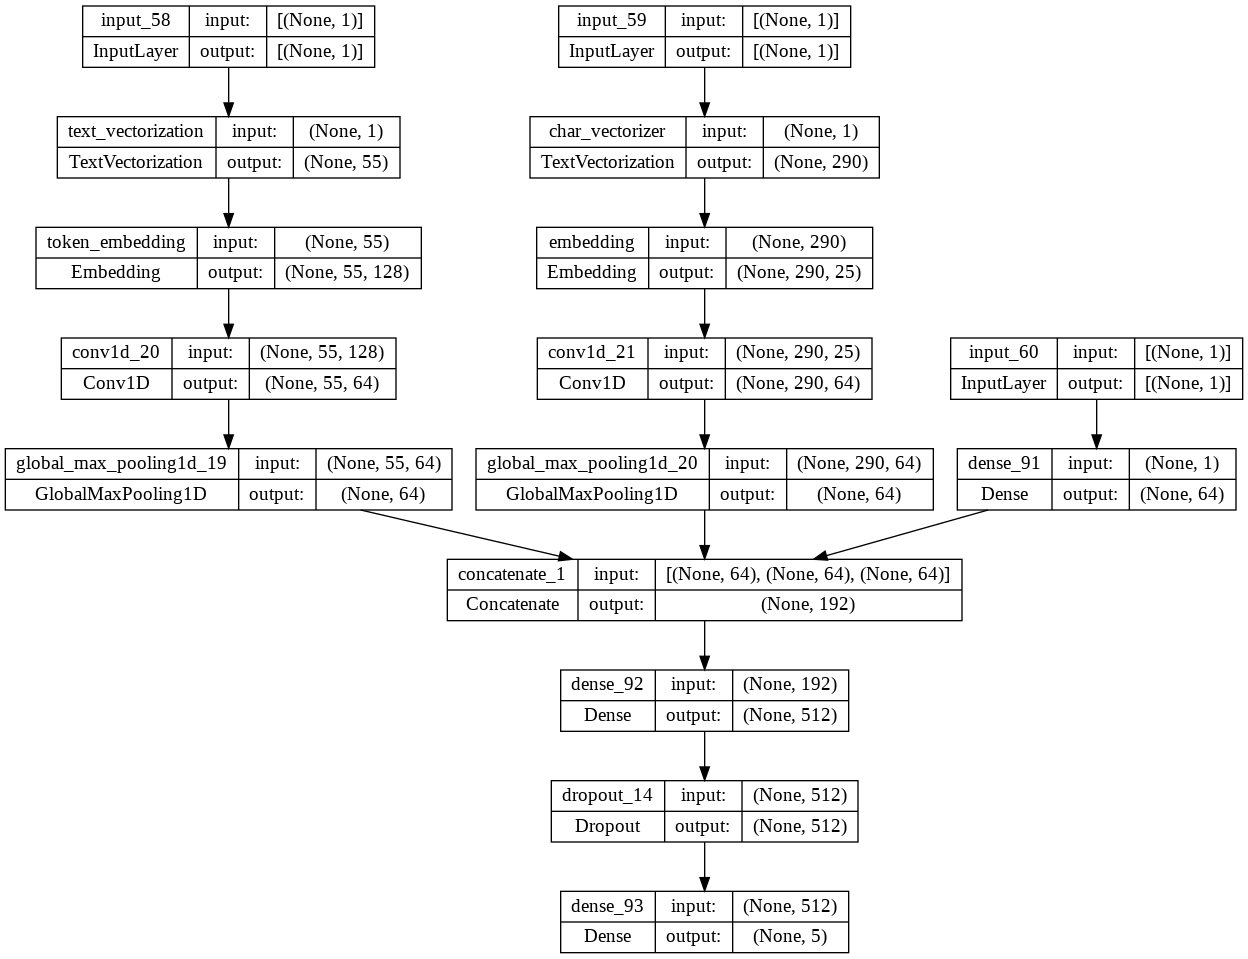

In [ ]:
plot_model(model_7, show_shapes=True)

In [ ]:
# Evaluate 
model_7.evaluate(val_model_5_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8547 - accuracy: 0.8864


[0.8546773195266724, 0.886435866355896]

In [ ]:
# Make predictions
model_7_pred_probs = model_7.predict(val_model_5_dataset)

945/945 [==============================] - 3s 3ms/step


In [ ]:
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)

In [ ]:
model_7_results = calculate_results(y_true=val_label_encoder,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 88.64358533033231,
 'precision': 0.8892945615061146,
 'recall': 0.8864358533033232,
 'f1': 0.8841134899760436}

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results})
all_model_results = all_model_results.transpose()

In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1,80.683172,0.805482,0.806832,0.805481
model_2,71.481531,0.715395,0.714815,0.711717
model_3,71.253144,0.721851,0.712531,0.705525
model_4,74.175824,0.743160,0.741758,0.739434
model_5,86.184298,0.867492,0.861843,0.858195
model_6,84.956309,0.853101,0.849563,0.845946
model_7,88.643585,0.889295,0.886436,0.884113


In [ ]:
all_model_results.accuracy = all_model_results.accuracy / 100

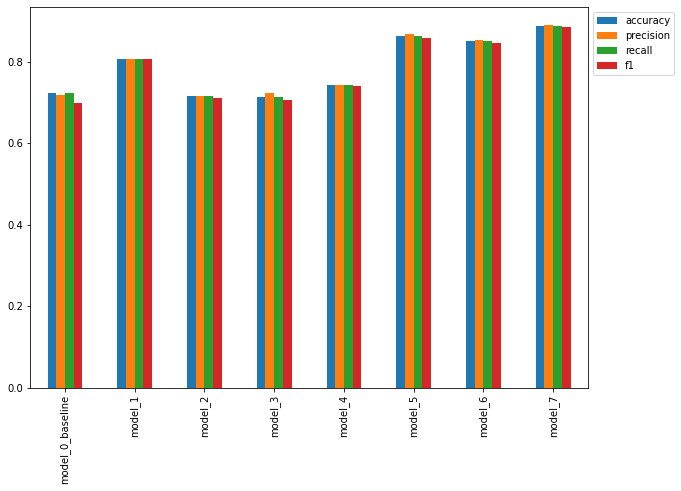

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

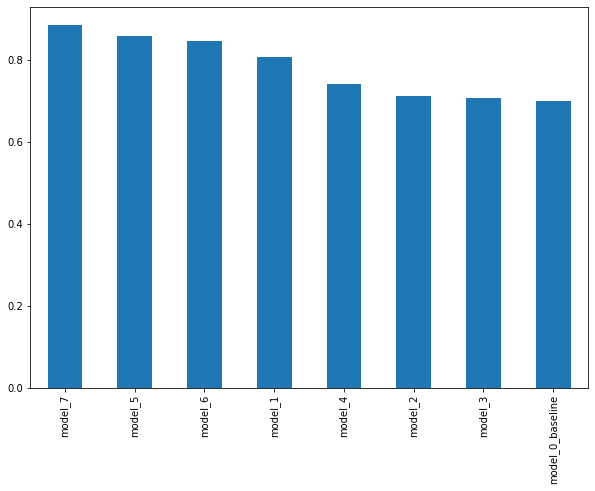

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));